In [1]:
import pandas as pd
import numpy as np


import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

### Solar power generation data for one plant gathered at 15 minutes intervals over a 34 days period.


In [2]:
plantOneGen = pd.read_csv('data/Plant_1_Generation_Data.csv')
display(plantOneGen.head())
plantOneGen.info()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,15-05-2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
1,15-05-2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2,15-05-2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
3,15-05-2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
4,15-05-2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    68778 non-null  object 
 1   PLANT_ID     68778 non-null  int64  
 2   SOURCE_KEY   68778 non-null  object 
 3   DC_POWER     68778 non-null  float64
 4   AC_POWER     68778 non-null  float64
 5   DAILY_YIELD  68778 non-null  float64
 6   TOTAL_YIELD  68778 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 3.7+ MB


### Weather sensor data gathered for one solar plant every 15 minutes over a 34 days period.

In [3]:
plantOneSensor = pd.read_csv('data/Plant_1_Weather_Sensor_Data.csv')
display(plantOneSensor.head())
plantOneSensor.info()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3182 entries, 0 to 3181
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE_TIME            3182 non-null   object 
 1   PLANT_ID             3182 non-null   int64  
 2   SOURCE_KEY           3182 non-null   object 
 3   AMBIENT_TEMPERATURE  3182 non-null   float64
 4   MODULE_TEMPERATURE   3182 non-null   float64
 5   IRRADIATION          3182 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 149.3+ KB


In [4]:
# Look at the vlues in the SOURCE_KEY for plant1 = this is the inverter ID - measurements are at the inverter level - each inverter has multiple lines of solar pannels connected to it 
# Inverter changes DC -> AC; allows the power to be either directly used or fed into the grid - there might be a pretty easy way to identify faulty inverters based off their converstion rate from DC -> AC.

display(pd.DataFrame(plantOneGen.SOURCE_KEY.value_counts().head()))
print('Number of Inverters at Plant 1: {}'.format(len(plantOneGen.SOURCE_KEY.value_counts().index)))

,SOURCE_KEY
bvBOhCH3iADSZry,3155
1BY6WEcLGh8j5v7,3154
7JYdWkrLSPkdwr4,3133
VHMLBKoKgIrUVDU,3133
ZnxXDlPa8U1GXgE,3130


Number of Inverters at Plant 1: 22


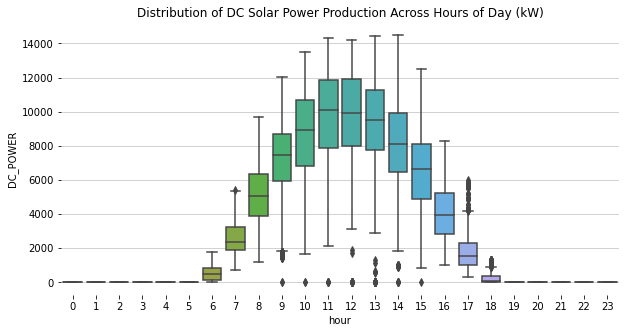

In [5]:
# quickly look at the general daily trend across all inverters at plant1

plantOneGen.DATE_TIME = pd.to_datetime(plantOneGen.DATE_TIME,format="%d-%m-%Y %H:%M")
plantOneGen['hour'] = plantOneGen.DATE_TIME.dt.hour
plt.figure(figsize=(10,5))
sns.boxplot(plantOneGen.hour, plantOneGen.DC_POWER)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().set_axisbelow(True)
plt.gca().grid(axis='y',alpha=.7)

plt.title('Distribution of DC Solar Power Production Across Hours of Day (kW)')
plt.show()

In [6]:
# see if there are any obvious outliers for the conversion rate to AC - just look at the average conversion rate when there is power being produced

plantOneGen['convRate'] = plantOneGen.AC_POWER / plantOneGen.DC_POWER # 
plantOneGen['convRate'].fillna(0, inplace=True)

withPower = plantOneGen.loc[plantOneGen.DC_POWER > 0,:]

grouped = withPower.groupby('SOURCE_KEY')

invGrouped = pd.DataFrame(grouped.convRate.mean())
invGrouped['std'] = grouped.convRate.std()
invGrouped = invGrouped.sort_values('std', ascending=False)
display(invGrouped.head())
invGrouped.tail()

,convRate,std
SOURCE_KEY,,
McdE0feGgRqW7Ca,0.097719,0.000504
sjndEbLyjtCKgGv,0.097725,0.000501
bvBOhCH3iADSZry,0.097733,0.000474
1BY6WEcLGh8j5v7,0.097729,0.000471
z9Y9gH1T5YWrNuG,0.097718,0.000462


,convRate,std
SOURCE_KEY,,
uHbuxQJl8lW7ozc,0.097716,0.000445
ZoEaEvLYb1n2sOq,0.097717,0.000444
pkci93gMrogZuBj,0.097718,0.000443
WRmjgnKYAwPKWDb,0.097718,0.000442
3PZuoBAID5Wc2HD,0.097714,0.000441


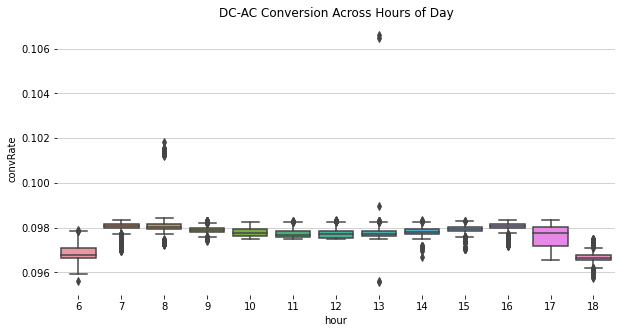

In [7]:

plt.figure(figsize=(10,5))
sns.boxplot(withPower.hour, withPower.convRate)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().set_axisbelow(True)
plt.gca().grid(axis='y',alpha=.7)

plt.title('DC-AC Conversion Across Hours of Day')
plt.show()

In [8]:
# join the data together to bring in some temperature data into exploratory analysis 

plantOneGen.set_index(pd.DatetimeIndex(plantOneGen['DATE_TIME']), inplace=True)
plantOneSensor.DATE_TIME = pd.to_datetime(plantOneSensor.DATE_TIME)
plantOneSensor.set_index(pd.DatetimeIndex(plantOneSensor['DATE_TIME']), inplace=True)

plantOneSensorJoin = plantOneSensor[['AMBIENT_TEMPERATURE','MODULE_TEMPERATURE','IRRADIATION']]

plantOneFull = pd.merge(plantOneGen, plantOneSensorJoin, how='left', right_index=True, left_index=True)

plantOneFull.head()


,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,hour,convRate,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
DATE_TIME,,,,,,,,,,,,
2020-05-15,2020-05-15,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,0,0.0,25.184316,22.857507,0.0
2020-05-15,2020-05-15,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0,0,0.0,25.184316,22.857507,0.0
2020-05-15,2020-05-15,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0,0,0.0,25.184316,22.857507,0.0
2020-05-15,2020-05-15,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0,0,0.0,25.184316,22.857507,0.0
2020-05-15,2020-05-15,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0,0,0.0,25.184316,22.857507,0.0


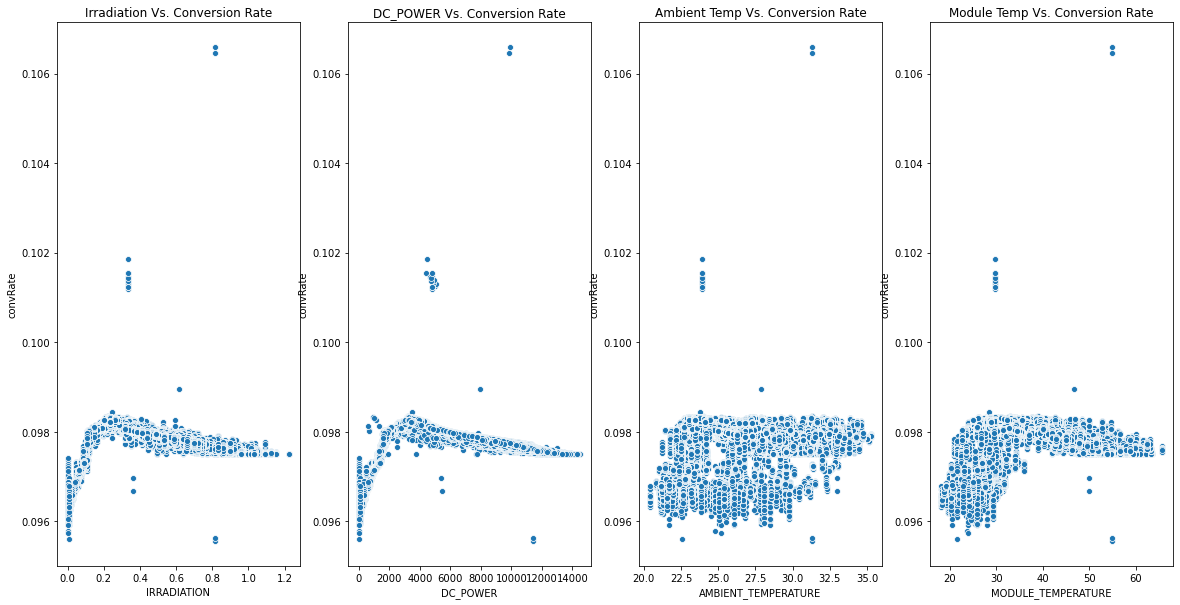

In [15]:

f , (a1, a2, a3, a4) = plt.subplots(nrows=1, ncols=4, figsize=(20,10))


sns.scatterplot(plantOneFull.loc[plantOneFull.convRate > 0, :].IRRADIATION,
            plantOneFull.loc[plantOneFull.convRate > 0, :].convRate,
               ax = a1)
a1.set_title('Irradiation Vs. Conversion Rate')

sns.scatterplot(plantOneFull.loc[plantOneFull.convRate > 0, :].DC_POWER,
            plantOneFull.loc[plantOneFull.convRate > 0, :].convRate,
               ax = a2)
a2.set_title('DC_POWER Vs. Conversion Rate')

sns.scatterplot(plantOneFull.loc[plantOneFull.convRate > 0, :].AMBIENT_TEMPERATURE,
            plantOneFull.loc[plantOneFull.convRate > 0, :].convRate,
               ax = a3)
a3.set_title('Ambient Temp Vs. Conversion Rate')

sns.scatterplot(plantOneFull.loc[plantOneFull.convRate > 0, :].MODULE_TEMPERATURE,
            plantOneFull.loc[plantOneFull.convRate > 0, :].convRate,
               ax = a4)
a4.set_title('Module Temp Vs. Conversion Rate')

plt.show()

# Look if there is a relatively simple way to see when an array of pannels could use cleaning 

# Plotting the 95% confidence interval for the OLS regression fit for the relationship between Sensor Irradiation readings and DC power output.
#### It seems that if the slope for the OLS line fit to the scatter data for each inverter is less than 13000, then it falls outside of the norm and may indicate that some pannels in the array need cleaning, or that there are faults in the system somewhere.
#### A more elaborate method would be to get the readings for each array when they're guarenteed to be clean - then base the change off that inverter's conversion rate from Irradiation to DC power.  This is due to the fact that there is only one sensor per power plant, and there may be shadows or other environmental factors that change what the average conversion rate (slope) would be for each individual sensor.

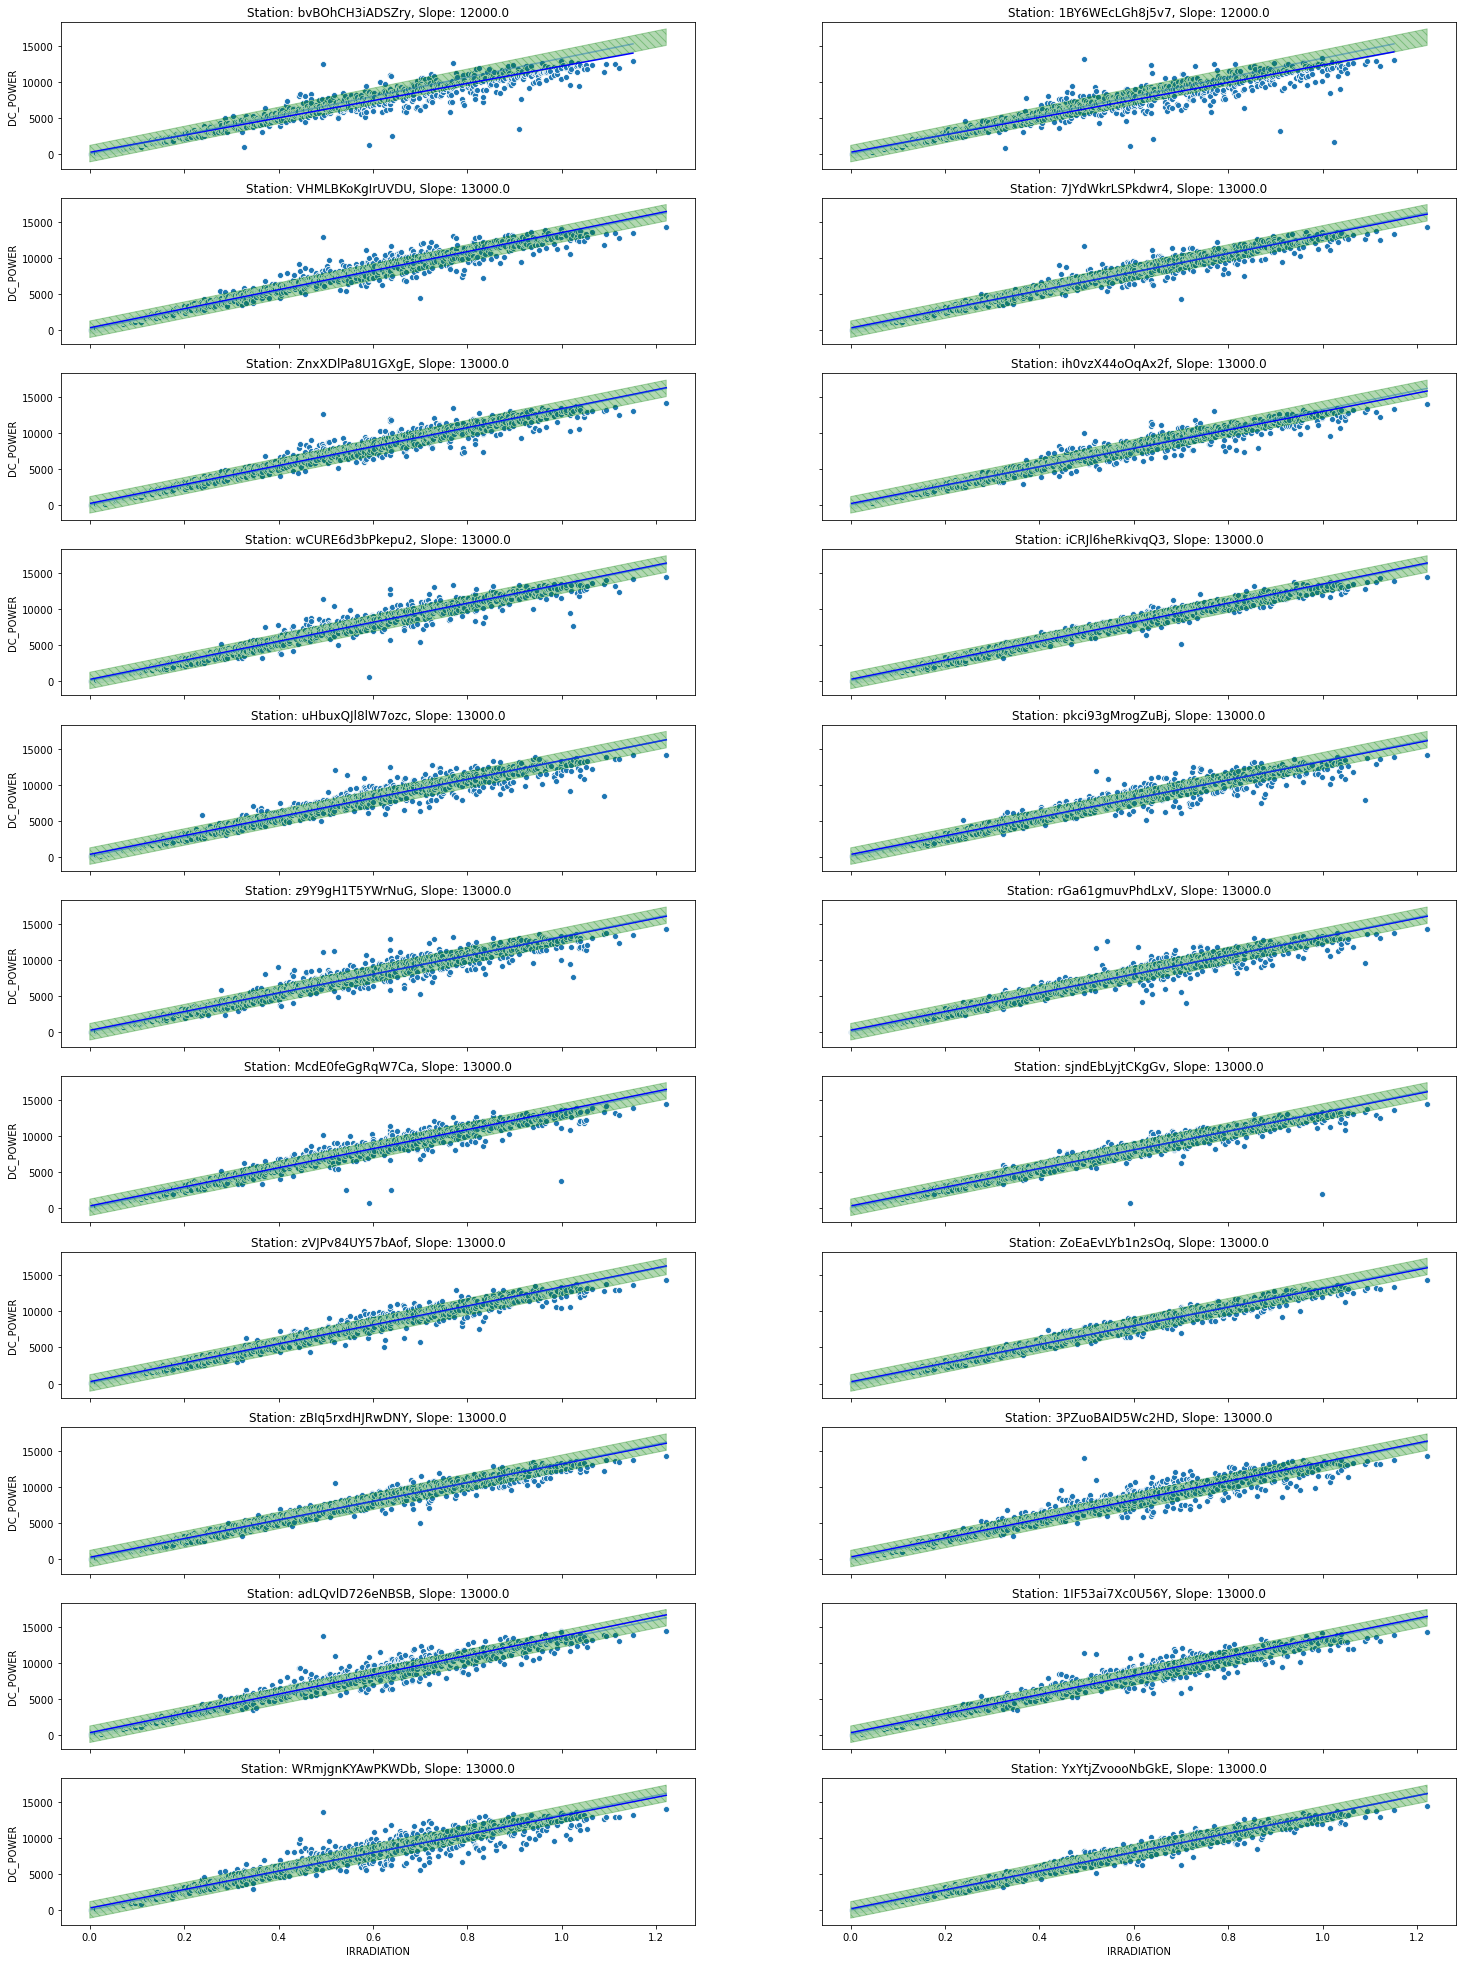

In [27]:
# lets look at the relationship between irradiation and dc power to see if there are any sections of solar pannels that could use some cleaning 
# using dc power rather than AC to not factor in potential poor inverters 
def line(slope, intercept, x):
    result = intercept + np.multiply(slope, x)
    return result

# build a dictionary in order to store the stations regression values
stations ={}

#gerneal relationship across all stations
plantOneTemp = pd.DataFrame(plantOneFull.dropna())
plantOneTemp.sort_values('IRRADIATION', ascending=True, inplace=True)
s, i, r, p, std_err = stats.linregress(plantOneTemp.IRRADIATION, plantOneTemp.DC_POWER)




plantOneTemp['x1'] = plantOneTemp.IRRADIATION.copy()
plantOneTemp['y'] = plantOneTemp.DC_POWER.copy()

results = smf.ols('y ~ x1', data=plantOneTemp).fit()

p, lower, upper = wls_prediction_std(results)

fitLine = results.fittedvalues


f, a = plt.subplots(nrows=11, ncols=2, figsize = (25,35),sharex=True, sharey=True)

a = a.ravel() 
counter = 0



for key in plantOneTemp.SOURCE_KEY.value_counts().index: # loop through the inverters
    axx = a[counter] # get our axis
    data = plantOneTemp.loc[plantOneTemp.SOURCE_KEY == key,['IRRADIATION','DC_POWER']]
    data = data.loc[data.DC_POWER != 0]
    slope, intercept, r, p, std_err = stats.linregress(data.IRRADIATION, data.DC_POWER)
    stations[key] = {'m':slope,
                    'b':intercept,
                    'r':r**2,
                    'p':p,
                    'std':std_err} 
    data['line'] = line(slope, intercept, data.IRRADIATION.values)
    
    
    sns.lineplot(data=data, x='IRRADIATION', y='line', color='b', ax=axx)
    sns.scatterplot(data=data, x='IRRADIATION', y='DC_POWER', ax=axx)
    axx.fill_between(plantOneTemp.IRRADIATION, upper.ravel(), lower.ravel(), color='g', hatch='\\\\\\', alpha=0.3, label='95% Confidence Interval From Overall Fit')
    axx.set_title('Station: {}, Slope: {}'.format(key, round(slope/1000, 0) * 1000))
    counter += 1
plt.show()    